# Preparação dos Dados

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
caminho_arquivo = '/content/drive/MyDrive/TCC - UFMS/TCC - UFMS - final/Modelo de Classificação de Sentimentos/Dados de Treinamento/anotacoes.csv'
df = pd.read_csv(caminho_arquivo)

In [5]:
df.head()

,Frase,Sentimento
0,mulher gulosa,Negativo
1,ela é cheirosa,Positivo
2,ela é charmosa,Positivo
3,menina delicada,Positivo
4,Ela é tão sexy,Negativo


In [6]:
df = df[df['Sentimento'].notna()]

In [7]:
categoria_counts = df['Sentimento'].value_counts()
print(categoria_counts)

Sentimento
Negativo    1550
Positivo    1498
Neutro       949
Neuto          1
Name: count, dtype: int64


In [8]:
X = df['Frase'].values  # Frases
y = df['Sentimento'].values  # Rótulos

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
df['Sentimento'] = df['Sentimento'].replace('Neuto', 'Neutro')

In [11]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentimento'])

In [12]:
classes_mapeadas = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(classes_mapeadas)

{'Negativo': 0, 'Neutro': 1, 'Positivo': 2}


In [13]:
from imblearn.over_sampling import RandomOverSampler

In [14]:
def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X, y = ros.fit_resample(X.reshape(-1, 1), y)
    return X.flatten(), y

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [16]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Treinamento

In [17]:
# treinamento
def train_model(model, data_loader, optimizer):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

# Avaliação

In [18]:
# avaliação
from sklearn.metrics import classification_report

def evaluate_model(model, data_loader):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Gera o classification report
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

    return accuracy, precision, recall, f1, class_report, all_preds


In [19]:
# tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validação Cruzada Estratificada


In [32]:
# Definir o número de folds para validação cruzada
n_splits = 30 #10 é o mais comum, mas pode aumentar o número de folds desde que contenha no minimo 30 exemplos em cada fold, ex: 100 exemplos anotados, deve ter no maximo 3 folds / Deve-se saber tbm, que quanto maior o número de folds, maior o custo computacional
skf = StratifiedKFold(n_splits=n_splits)

In [33]:
# Otimizador
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
all_fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [35]:
all_true_labels = []
all_pred_labels = []

# Treinamento e Avaliação de Modelo com Validação Cruzada Estratificada e Balanceamento de Classes

In [36]:
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Dividir os dados em treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Balancear as classes no conjunto de treino
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

    # Criar datasets e dataloaders
    train_dataset = TextDataset(X_train_balanced, y_train_balanced, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # mini-batch de tamanho 16 e shuffle para pegar amostras aleatórias
    test_loader = DataLoader(test_dataset, batch_size=16) # mini-batch de tamanho 16

    # Treinar o modelo no fold atual
    train_loss = train_model(model, train_loader, optimizer)
    print(f"Loss de treino no Fold {fold+1}: {train_loss}") #quanto menor a loss em cada fold significa que o modelo está aprendendo

    # Avaliar o modelo no fold atual
    accuracy, precision, recall, f1, class_report, all_preds = evaluate_model(model, test_loader)
    #print(f"Acurácia no Fold {fold+1}: {accuracy}")
    #print(f"Precisão no Fold {fold+1}: {precision}")
    #print(f"Recall no Fold {fold+1}: {recall}")
    #print(f"F1-score no Fold {fold+1}: {f1}")
    #print(f"Classification Report no Fold {fold+1}:\n{class_report}")

    # Armazenar métricas para cada fold
    all_fold_metrics['accuracy'].append(accuracy)
    all_fold_metrics['precision'].append(precision)
    all_fold_metrics['recall'].append(recall)
    all_fold_metrics['f1'].append(f1)

    all_true_labels.extend(y_test)
    all_pred_labels.extend(all_preds)

# Cálculo das métricas finais (médias)
final_accuracy = np.mean(all_fold_metrics['accuracy'])
final_precision = np.mean(all_fold_metrics['precision'])
final_recall = np.mean(all_fold_metrics['recall'])
final_f1 = np.mean(all_fold_metrics['f1'])


print(f"\nDesempenho Final:")
print(f"Accuracy Média: {final_accuracy}")
print(f"Precision Média: {final_precision}")
print(f"Recall Médio: {final_recall}")
print(f"F1-score Médio: {final_f1}")

# Geração do Classification Report geral
final_class_report = classification_report(all_true_labels, all_pred_labels, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(final_class_report)

Fold 1/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 1: 0.0424787908915954
Fold 2/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 2: 0.03001380386431718
Fold 3/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 3: 0.0335134056384768
Fold 4/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 4: 0.024095353049605594
Fold 5/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 5: 0.02289209574845444
Fold 6/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 6: 0.024949557276349846
Fold 7/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 7: 0.025194785493990287
Fold 8/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 8: 0.024530156751372933
Fold 9/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 9: 0.021308661023613888
Fold 10/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 10: 0.010499164768352979
Fold 11/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 11: 0.019992882279688293
Fold 12/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 12: 0.028735622909463597
Fold 13/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 13: 0.01920957177474737
Fold 14/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 14: 0.013080168670802328
Fold 15/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 15: 0.018532983794248267
Fold 16/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 16: 0.010837069490105843
Fold 17/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 17: 0.010236364693088404
Fold 18/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 18: 0.027050021686176918
Fold 19/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 19: 0.010232376847192446
Fold 20/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 20: 0.014336850178457823
Fold 21/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 21: 0.010060009976117442
Fold 22/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 22: 0.008119328545725571
Fold 23/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 23: 0.020942863783725216
Fold 24/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 24: 0.016275494861061907
Fold 25/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 25: 0.0077536172221240535
Fold 26/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 26: 0.008720283383228618
Fold 27/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 27: 0.01648753203066885
Fold 28/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 28: 0.012845136972995894
Fold 29/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 29: 0.009471457869356088
Fold 30/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Loss de treino no Fold 30: 0.0062574100963844

Desempenho Final:
Accuracy Média: 0.9957655332360752
Precision Média: 0.9958867777509581
Recall Médio: 0.9957655332360752
F1-score Médio: 0.9957671361831958

Classification Report:
              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00      1550
      Neutro       0.99      0.99      0.99       950
    Positivo       1.00      1.00      1.00      1498

    accuracy                           1.00      3998
   macro avg       1.00      1.00      1.00      3998
weighted avg       1.00      1.00      1.00      3998



Baixar modelo para uso posterior

In [37]:
!mkdir model
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

!zip -r /content/model.zip /content/model

from google.colab import files
files.download("/content/model.zip")

mkdir: cannot create directory ‘model’: File exists
updating: content/model/ (stored 0%)
updating: content/model/vocab.txt (deflated 52%)
updating: content/model/tokenizer_config.json (deflated 74%)
updating: content/model/model.safetensors (deflated 7%)
updating: content/model/special_tokens_map.json (deflated 42%)
updating: content/model/config.json (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Utilizando o Modelo para a análise infantil

In [38]:
caminho_arquivo1 = '/content/drive/MyDrive/Linguamática/Sexualização Infantil/categorias - infantil.csv'
df1 = pd.read_csv(caminho_arquivo1)

In [39]:
df1.head()

,Padrão,Frase,Nome da Música,Nome do Artista,Gênero Musical,Letra da Música,Categoria
0,sujeitoauxadjetivo,bebê cara é foda,Coração de Gelo,WIU,Rap,"Get-get it, get it up, get it up, get it up, b...",Aparência
1,sujeitoadjetivo,criança má,Bronzes e Cristais,Maysa,MPB,Se alguém contar pelos dedos Quantas alegrias ...,Emoção
2,sujeitoadjetivo,criança cheia,Sou Rebelde (Soy Rebelde),Lilian,Jovem Guarda,Eu sou rebelde porque o mundo quis assim Porqu...,Aparência
3,ficar_parecer_tornar,novinha saliente fica loucona,Bum Bum Tam Tam,MC Fioti,Funk,É a flauta envolvente que mexe com a mente De ...,Aparência
4,sujeitoadjetivo,novinha saliente,Bum Bum Tam Tam,MC Fioti,Funk,É a flauta envolvente que mexe com a mente De ...,Aparência


In [40]:
df1.shape

(593, 7)

In [41]:
sentencas = df1['Frase'].tolist()

In [42]:
batch_size = 16
predicoes_finais = []
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [43]:
# mini batch
for i in range(0, len(sentencas), batch_size):
    sentencas_lote = sentencas[i:i+batch_size]

    tokens = tokenizer(
        sentencas_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais.extend(pred_classes)

{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Papel Social': 3, 'Sexual': 4}



In [44]:
df1['Sentimento'] = predicoes_finais
#{'Negativo': 0, 'Neutro': 1, 'Positivo': 2}
df1['Sentimento'] = df1['Sentimento'].map({0: 'Negativo', 1: 'Neutro', 2: 'Positivo'})


In [45]:
from google.colab import files

df1.to_csv('df1_com_previsoes.csv', index=False)
files.download('df1_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
sentimento_counts_df1 = df1['Sentimento'].value_counts()
print(sentimento_counts_df1)

Sentimento
Negativo    298
Positivo    194
Neutro      101
Name: count, dtype: int64


# Utilizando o Modelo para a análise de como as mulheres se retratam

In [47]:
caminho_arquivo2 = '/content/drive/MyDrive/Linguamática/Sexualização Infantil/categorias - mulher by mulher.csv'
df2 = pd.read_csv(caminho_arquivo2)

In [48]:
df2.head()

,Padrão,Frase,Nome da Música,Nome do Artista,Gênero Musical,Letra da Música,Categoria
0,sujeitoauxadjetivo,eu estava apaixonada,Meiga e abusada,Anitta,Pop,"Eu, posso conquistar tudo que eu quero Mas, fo...",Emoção
1,sujeitoadjetivo,eu (louca,"Pretin (Verão, Pt. 1)",Flora Matos,Rap,Pretin Desse jeito cê me deixa louca Tomando c...,Caráter
2,sujeitoauxadjetivo,eu (foi mais forte,Tudo Aconteceu,MC Du Black,Funk,"Ei, Delacruz na voz Du Black na voz, na voz, n...",Aparência
3,sujeitoauxadjetivo,eu juro que eu quero me mudar daqui vou atrás ...,Deus é por nós,MC Marks,Funk,"(Ai, ai, ai, ai, ai) (Ai, ai, ai, ai, ai) (É o...",Emoção
4,sujeitoauxadjetivo,eu tô preparada,Desce Pro Play (PA PA PA),ZAAC,Funk,"[MC Zaac] Pa, pa, pa, pa, pa, pa, pa, pa, pa, ...",Emoção


In [49]:
df2.shape

(1621, 7)

In [50]:
sentencasMasc = df2['Frase'].tolist()

In [51]:
batch_size = 16

predicoes_finais2 = []

model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [52]:
# mini batch
for i in range(0, len(sentencasMasc), batch_size):
    sentencas2_lote = sentencasMasc[i:i+batch_size]

    tokens = tokenizer(
        sentencas2_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs2 = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes2 = torch.argmax(outputs2.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais2.extend(pred_classes2)

In [53]:
df2['Sentimento'] = predicoes_finais2

df2['Sentimento'] = df2['Sentimento'].map({0: 'Negativo', 1: 'Neutro', 2: 'Positivo'})

In [54]:
from google.colab import files

df2.to_csv('df2_com_previsoes.csv', index=False)
files.download('df2_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
sentimento_counts_df2 = df2['Sentimento'].value_counts()
print(sentimento_counts_df2)

Sentimento
Negativo    729
Positivo    559
Neutro      333
Name: count, dtype: int64


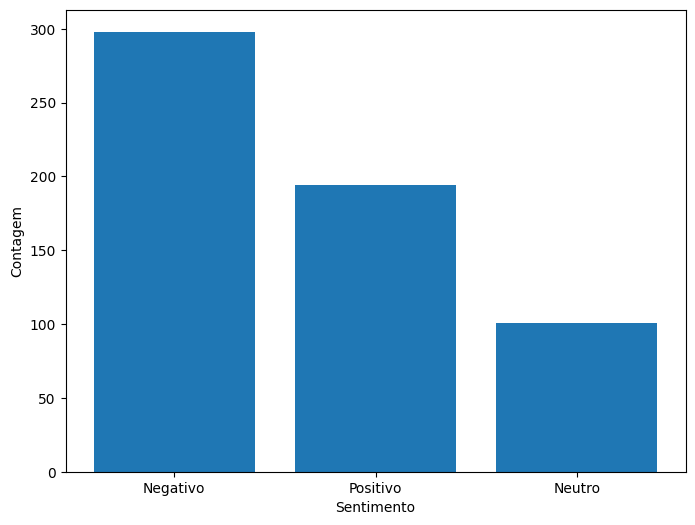

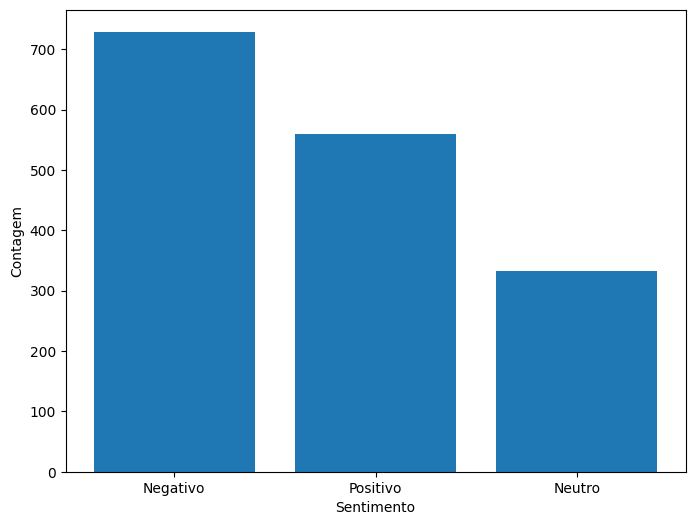

In [56]:
import matplotlib.pyplot as plt

# Gráfico para df1
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts_df1.index, sentimento_counts_df1.values)
#plt.title('Distribuição de Sentimentos (Infantil)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()

# Gráfico para df2
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts_df2.index, sentimento_counts_df2.values)
#plt.title('Distribuição de Sentimentos (Interprete)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()
